In [2]:
import pandas as pd
from ast import literal_eval
import nltk
import re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
!pip freeze | grep scipy

scipy==1.10.1


# Load Datasets

We load the preprocessed datasets. Make sure to run the previous notebooks first, so the files are present.

## media

In [4]:
df_media = pd.read_csv('../data/cleantech-media.csv', converters={"token_content": literal_eval}, parse_dates=['date'])
df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9588 entries, 0 to 9587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          9588 non-null   object        
 1   date           9588 non-null   datetime64[ns]
 2   author         31 non-null     object        
 3   content        9588 non-null   object        
 4   domain         9588 non-null   object        
 5   url            9588 non-null   object        
 6   token_content  9588 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 524.5+ KB


In [5]:
df_media.head(5)

,title,date,author,content,domain,url,token_content
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,Qatar Petroleum ( QP) is targeting aggressive ...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[qatar, petroleum, qp, target, aggress, cut, g..."
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,Nuclear Power Corp. of India Ltd. ( NPCIL) syn...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[nuclear, power, corp, india, ltd, npcil, sync..."
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,New US President Joe Biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[new, us, presid, joe, biden, take, offic, wee..."
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,The slow pace of Japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[slow, pace, japanes, reactor, restart, contin..."
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,Two of New York City's largest pension funds s...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[two, new, york, citi, larg, pension, fund, sa..."


## patents

In [6]:
df_patents = pd.read_csv('../data/google_patents.csv', converters={"token_content": literal_eval}, parse_dates=['publication_date'])
df_patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13199 entries, 0 to 13198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  13199 non-null  object        
 1   application_number  13199 non-null  object        
 2   country_code        13199 non-null  object        
 3   publication_date    13199 non-null  datetime64[ns]
 4   inventor            13199 non-null  object        
 5   title               13199 non-null  object        
 6   abstract            13199 non-null  object        
 7   abstract_lang       13199 non-null  object        
 8   token_content       13199 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 928.2+ KB


In [7]:
df_patents.head()

,publication_number,application_number,country_code,publication_date,inventor,title,abstract,abstract_lang,token_content
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,['en'],"[disclos, adapt, dc, ac, invert, system, oper,..."
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,[],System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",['en'],"[accord, exampl, embodi, solar, energi, system..."
2,US-11396827-B2,US-202117606042-A,US,2022-07-26,[],Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,['en'],"[control, method, optim, solar, power, effici,..."
3,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,[],Low-carbon running saline wastewater treatment...,The invention discloses a system and a method ...,"['zh', 'en']","[invent, disclos, system, method, treat, low, ..."
4,CN-217026795-U,CN-202220668705-U,CN,2022-07-22,[],Water ecological remediation device convenient...,The utility model discloses a water ecological...,"['zh', 'en']","[util, model, disclos, water, ecolog, restor, ..."


# Pre-processing

Mostly taken form previous notebook, but without lemmatizing/stemming.

In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pascal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preprocess_text(text):

    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]+', '', text)

    # tokenize the text
    re_tokens = re.findall('[\w]+', text)

    # remove stopwords
    filtered_stopwords = []
    for word in re_tokens:
        if word.lower() not in stop_words_nltk:
            filtered_stopwords.append(word.lower())
        else:
            pass

    return filtered_stopwords

preprocess_text('This, my Friend, is a % test. Have I passed?')

['friend', 'test', 'passed']

In [10]:
%%time 
media_tokens = df_media['content'].apply(lambda x: preprocess_text(x))

CPU times: user 7.69 s, sys: 72 ms, total: 7.76 s
Wall time: 7.82 s


In [11]:
media_tokens[:10]

0    [qatar, petroleum, qp, targeting, aggressive, ...
1    [nuclear, power, corp, india, ltd, npcil, sync...
2    [new, us, president, joe, biden, took, office,...
3    [slow, pace, japanese, reactor, restarts, cont...
4    [two, new, york, citys, largest, pension, fund...
5    [japans, supreme, court, likely, become, arbit...
6    [oil, natural, gas, industry, officials, looki...
7    [new, great, game, emerging, energy, business,...
8    [close, th, anniversary, fukushima, daiichi, d...
9    [coldest, weather, generation, brought, widesp...
Name: content, dtype: object

In [12]:
# number of words
len([word for sublist in media_tokens for word in sublist])

4314610

In [13]:
# number of unique words
len(set([word for sublist in media_tokens for word in sublist]))

87078

In [14]:
%%time
patent_tokens = df_patents['abstract'].apply(lambda x: preprocess_text(x))

CPU times: user 2.65 s, sys: 25.1 ms, total: 2.68 s
Wall time: 2.69 s


In [15]:
patent_tokens[:10]

0    [disclosed, adaptable, dcac, inverter, system,...
1    [accordance, example, embodiment, solar, energ...
2    [control, method, optimizing, solartopower, ef...
3    [invention, discloses, system, method, treatin...
4    [utility, model, discloses, water, ecological,...
5    [invention, relates, technical, field, energy,...
6    [utility, model, discloses, solar, energy, bre...
7    [utility, model, provides, vehiclemounted, hyd...
8    [invention, discloses, mobile, energy, storage...
9    [utility, model, discloses, solar, photovoltai...
Name: abstract, dtype: object

In [16]:
# number of words
len([word for sublist in patent_tokens for word in sublist])

1534180

In [17]:
# number of unique words
len(set([word for sublist in patent_tokens for word in sublist]))

20002

# Generate Word Embeddings

## Train baseline model with default params

First we train a baseline model for both datasets with default options. 

In [18]:
%%time
# train model with default params
media_embeddings_model = Word2Vec(sentences=media_tokens, seed=42)

CPU times: user 27.3 s, sys: 94.9 ms, total: 27.4 s
Wall time: 9.77 s


In [19]:
%%time
# train model with default params
patent_embeddings_model = Word2Vec(sentences=patent_tokens, seed=42)

CPU times: user 7.82 s, sys: 38.6 ms, total: 7.86 s
Wall time: 2.83 s


## Evaluate baseline models

In [20]:
def nearest_words(word, top_n=10):
    print(f'Most similar words to "{word}" in both models')
    return pd.concat([
        pd.DataFrame(media_embeddings_model.wv.most_similar(word, topn=top_n), columns=['media_word', 'media_dist']), 
        pd.DataFrame(patent_embeddings_model.wv.most_similar(word, topn=top_n), columns=['patent_word', 'patent_dist'])
    ], axis=1)
    
nearest_words('solar')

Most similar words to "solar" in both models


,media_word,media_dist,patent_word,patent_dist
0,photovoltaic,0.582027,photovoltaic,0.655758
1,rooftop,0.525048,sunlight,0.551163
2,utilityscale,0.473245,conversion,0.500955
3,renewable,0.462822,reflector,0.486818
4,bifacial,0.457997,sun,0.478847
5,groundmounted,0.447997,electric,0.475483
6,installed,0.441266,absorbing,0.453669
7,residential,0.424021,folding,0.448498
8,pv,0.422101,also,0.448135
9,distributed,0.419907,cell,0.445107


In [21]:
nearest_words("oil")

Most similar words to "oil" in both models


,media_word,media_dist,patent_word,patent_dist
0,silane,0.592512,highpressure,0.670159
1,natural,0.570261,steam,0.612963
2,upstream,0.541150,brine,0.607077
3,flared,0.534483,lowpressure,0.602527
4,sour,0.508441,sludge,0.598909
5,inflating,0.502981,ultrahightemperature,0.593601
6,downstream,0.502514,crude,0.593119
7,petroleum,0.500371,lubricating,0.590646
8,russian,0.491968,booster,0.586919
9,flue,0.485977,fume,0.582730


In [22]:
nearest_words("sun")

Most similar words to "sun" in both models


,media_word,media_dist,patent_word,patent_dist
0,shining,0.750696,sunlight,0.823124
1,blowing,0.718020,irradiation,0.774429
2,sunlight,0.618521,always,0.771430
3,rays,0.590592,incident,0.769285
4,night,0.581049,shading,0.751898
5,angle,0.579588,irradiated,0.716645
6,currents,0.572576,sunshine,0.711813
7,cable,0.571796,inclination,0.704588
8,sunshine,0.559581,shining,0.699950
9,shade,0.555350,sunny,0.694929


In [23]:
media_embeddings_model.wv.similarity('oil', 'solar')

-0.009125706

In [24]:
media_embeddings_model.wv.similarity('sun', 'solar')

0.36058614

In [25]:
media_embeddings_model.wv.similarity('renewable', 'solar')

0.4628222

In [26]:
media_embeddings_model.wv.similarity('renewable', 'oil')

0.053130545

In [27]:
patent_embeddings_model.wv.similarity('oil', 'solar')

-0.050862856

In [28]:
patent_embeddings_model.wv.similarity('sun', 'solar')

0.47884703

In [29]:
patent_embeddings_model.wv.similarity('renewable', 'solar')

0.221706

In [30]:
patent_embeddings_model.wv.similarity('renewable', 'oil')

0.03977844

### Get most frequent words and see their position in 2D-space


In [31]:
FREQUENCY = 50

In [32]:
# Use Counter to count occurrences of each word in both datasets combined
word_counts = Counter([word for sublist in media_tokens for word in sublist] + [word for sublist in patent_tokens for word in sublist])

# Get the most common words and their counts
most_common_words = word_counts.most_common(FREQUENCY)
most_common_words[:10]

[('energy', 92514),
 ('solar', 62152),
 ('power', 38257),
 ('water', 24065),
 ('storage', 23834),
 ('new', 21884),
 ('gas', 21129),
 ('wind', 20581),
 ('device', 18968),
 ('system', 18940)]

In [33]:
media_word_vecs = []
patent_word_vecs = []
labels = []

for word, count in most_common_words:
    try:
        media_word_vecs.append(media_embeddings_model.wv.get_vector(word))
    except:
        media_word_vecs.append(np.empty(100,))
    try:
        patent_word_vecs.append(patent_embeddings_model.wv.get_vector(word))
    except:
        patent_word_vecs.append(np.empty(100,))
    labels.append(word)
    
media_word_vecs = np.array(media_word_vecs)
patent_word_vecs = np.array(patent_word_vecs)
    
(patent_word_vecs.shape, media_word_vecs.shape)

((50, 100), (50, 100))

In [34]:
# show sample word vector
patent_word_vecs[0]

array([-0.80223918,  2.7267592 , -0.47459358, -0.76068503,  0.49042946,
        1.2371738 , -1.70959997, -1.69248962, -1.86907673, -0.10133494,
        1.0516057 ,  2.72436285,  1.93623483, -0.20196122,  0.06417093,
        1.05901933, -1.84699225, -1.72861803,  0.59554893, -0.57530332,
        2.7006166 , -1.31807244, -1.22044337,  1.12787127,  0.53111458,
        1.70570648,  0.90552509, -1.53738713,  1.14169645,  0.74795789,
       -1.22008467, -0.71991426, -0.8761977 ,  0.02821421,  0.70563924,
       -1.78884554,  0.91578794, -0.33677602, -2.04108572,  0.48516205,
        0.3151812 , -0.81220639,  0.40333021,  0.38795713,  0.31010363,
        0.17228267, -0.09968325,  0.82116354, -0.61804199, -0.36737102,
        0.72540915,  0.48674431,  1.12401974, -0.6905455 ,  0.11663754,
       -0.37922442, -0.6728012 , -0.01811949,  1.21117723, -2.0953021 ,
        0.69039887,  0.24156895, -2.29002142,  2.80773735, -1.40535378,
       -0.18965995,  0.79094183,  0.32907596, -1.49240851, -0.50

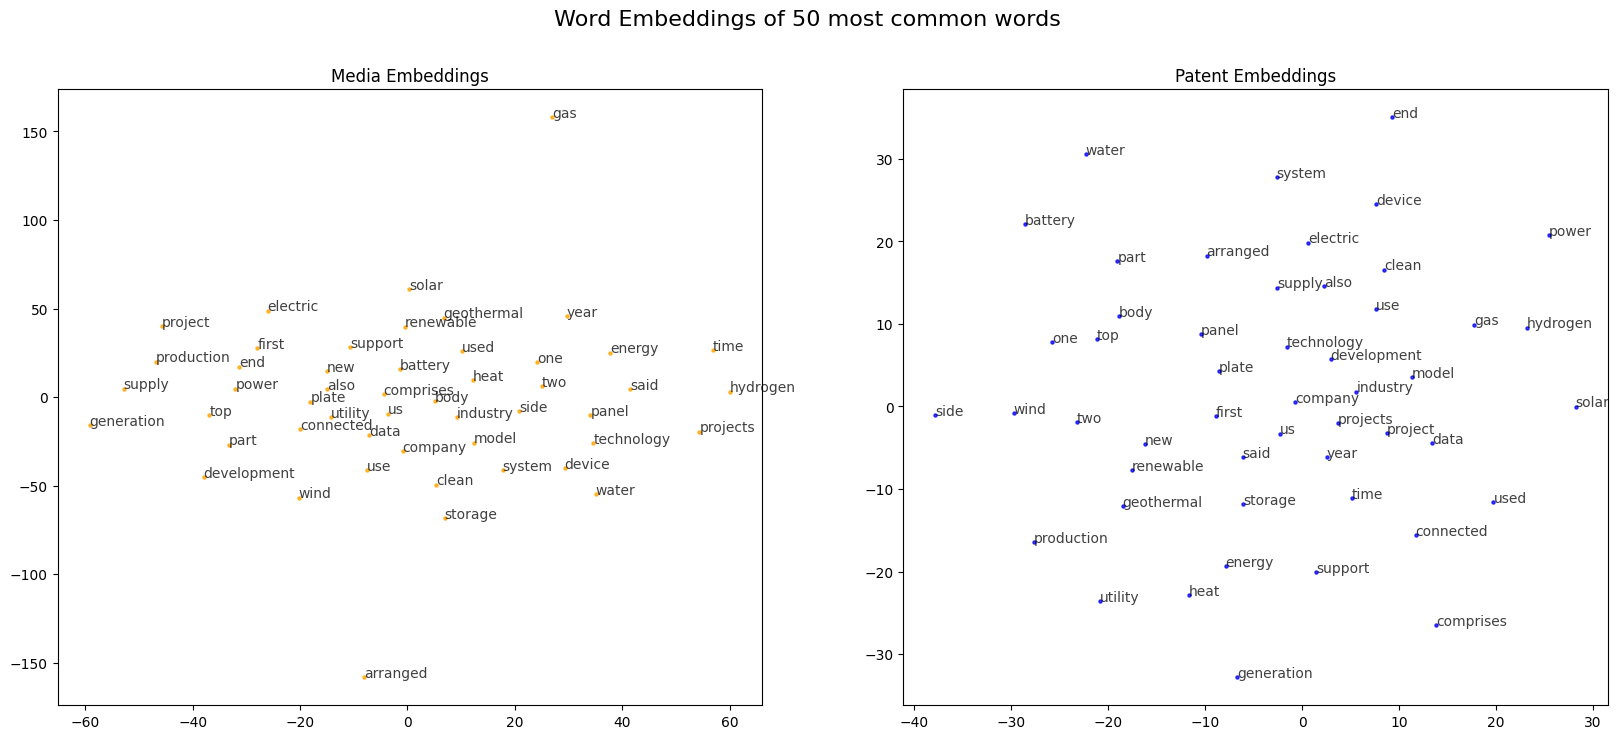

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

tsne_media = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T_media = tsne_media.fit_transform(media_word_vecs)

ax1.set_title('Media Embeddings')
ax1.scatter(T_media[:, 0], T_media[:, 1], c='Orange', alpha=0.75, s=5)
for label, x, y in zip(labels, T_media[:, 0], T_media[:, 1]):
    ax1.annotate(label,
                 xy=(x, y),
                 xytext=(0, 0),
                 alpha=0.75,
                 textcoords='offset points')

tsne_patents = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T_patents = tsne_patents.fit_transform(patent_word_vecs)

ax2.set_title('Patent Embeddings')
ax2.scatter(T_patents[:, 0], T_patents[:, 1], c='Blue', alpha=0.75, s=5)
for label, x, y in zip(labels, T_patents[:, 0], T_patents[:, 1]):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(0, 0),
                 alpha=0.75,
                 textcoords='offset points')

plt.suptitle(f'Word Embeddings of {FREQUENCY} most common words', fontsize=16)
plt.show()

# Train with different hyperparameters

In [36]:
from tqdm import tqdm

In [37]:
%%time

hyperparams = [
    [64, 2, 5],
    [64, 5, 5],
    [64, 10, 10],
    [128, 2, 5],
    [128, 5, 5],
    [128, 10, 5],
    [256, 2, 5],
    [256, 5, 5],
    [256, 5, 10],
]

media_models = []

for [vector_size, window, epochs] in tqdm(hyperparams, ncols=100):
    media_models.append((f'{vector_size}_{window}_{epochs}', Word2Vec(sentences=media_tokens, vector_size=vector_size, window=window, epochs=epochs, seed=42)))

media_models

100%|█████████████████████████████████████████████████████████████████| 9/9 [01:59<00:00, 13.29s/it]

CPU times: user 5min 34s, sys: 1.29 s, total: 5min 35s
Wall time: 1min 59s


[('64_2_5', <gensim.models.word2vec.Word2Vec at 0x2b9451fd0>),
 ('64_5_5', <gensim.models.word2vec.Word2Vec at 0x2b9451970>),
 ('64_10_10', <gensim.models.word2vec.Word2Vec at 0x2f0299220>),
 ('128_2_5', <gensim.models.word2vec.Word2Vec at 0x2f0299340>),
 ('128_5_5', <gensim.models.word2vec.Word2Vec at 0x2f0299190>),
 ('128_10_5', <gensim.models.word2vec.Word2Vec at 0x2f02991c0>),
 ('256_2_5', <gensim.models.word2vec.Word2Vec at 0x2f0299a30>),
 ('256_5_5', <gensim.models.word2vec.Word2Vec at 0x2f0299f10>),
 ('256_5_10', <gensim.models.word2vec.Word2Vec at 0x2f0299400>)]

In [38]:
%%time

patent_models = []

for [vector_size, window, epochs] in tqdm(hyperparams, ncols=100):
    patent_models.append((f'{vector_size}_{window}_{epochs}', Word2Vec(sentences=patent_tokens, vector_size=vector_size, window=window, epochs=epochs, seed=42)))

patent_models

100%|█████████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.06s/it]

CPU times: user 1min 38s, sys: 482 ms, total: 1min 39s
Wall time: 36.5 s


[('64_2_5', <gensim.models.word2vec.Word2Vec at 0x2e2ecb820>),
 ('64_5_5', <gensim.models.word2vec.Word2Vec at 0x298334e50>),
 ('64_10_10', <gensim.models.word2vec.Word2Vec at 0x2b7405100>),
 ('128_2_5', <gensim.models.word2vec.Word2Vec at 0x2b7405220>),
 ('128_5_5', <gensim.models.word2vec.Word2Vec at 0x2ef0fa430>),
 ('128_10_5', <gensim.models.word2vec.Word2Vec at 0x2ef0fa490>),
 ('256_2_5', <gensim.models.word2vec.Word2Vec at 0x2f0299fd0>),
 ('256_5_5', <gensim.models.word2vec.Word2Vec at 0x2f0299580>),
 ('256_5_10', <gensim.models.word2vec.Word2Vec at 0x2f0299b80>)]

# Assess the embedding quality

In [39]:
# append baseline models
media_models.append(('baseline', media_embeddings_model))
patent_models.append(('baseline', patent_embeddings_model))

In [40]:
# use only the word vectors
media_models = [(model_name, model.wv) for model_name, model in media_models]
patent_models = [(model_name, model.wv) for model_name, model in patent_models]

In [41]:
# load pre-trained model for reference
import gensim.downloader as api

google_news_model = api.load("word2vec-google-news-300")

In [42]:
# include google model
media_models.append(('google-news', google_news_model))
patent_models.append(('google-news', google_news_model))

## assess similar meanings 

In this sections we look at words which have similar meaning and/or should be close together in vector space. We do this by looking at the cosine similarity between words which yields an output betweent -1 and 1. For the similar meanings we expect the values to be as large as possible (close to 1).

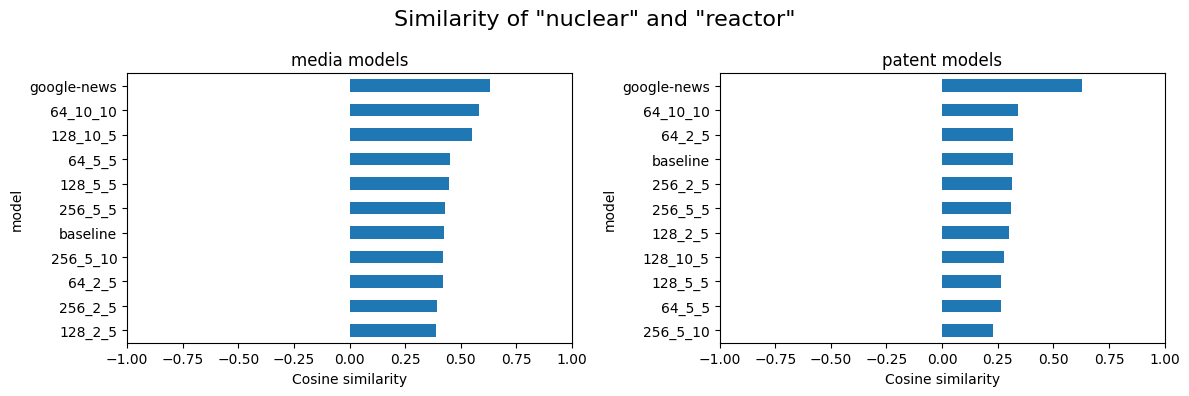

media median: 0.43
patent median: 0.31


In [43]:
# function to plot the distances
def plot_word_similarities(word_one, word_two, ascending=True): 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # media models
    df_media = pd.DataFrame([[model_name, model.similarity(word_one, word_two)] for model_name, model in media_models], 
                 columns=['model', 'similarity']).set_index('model').sort_values('similarity', ascending=ascending)
    df_media.plot(kind='barh', ax=ax1, title='media models', legend=False)
    
    # patent models
    df_patent = pd.DataFrame([[model_name, model.similarity(word_one, word_two)] for model_name, model in patent_models], 
                 columns=['model', 'similarity']).set_index('model').sort_values('similarity', ascending=ascending)
    df_patent.plot(kind='barh', ax=ax2, title='patent models', legend=False)

    ax1.set_xlabel('Cosine similarity')
    ax2.set_xlabel('Cosine similarity')
    ax1.set_xlim([-1,1])
    ax2.set_xlim([-1,1])
    
    fig.suptitle(f'Similarity of "{word_one}" and "{word_two}"', fontsize=16)
    fig.tight_layout()
    plt.show()

    print(f'media median: {df_media.similarity.median():.2f}')
    print(f'patent median: {df_patent.similarity.median():.2f}')

# first example
plot_word_similarities('nuclear', 'reactor')

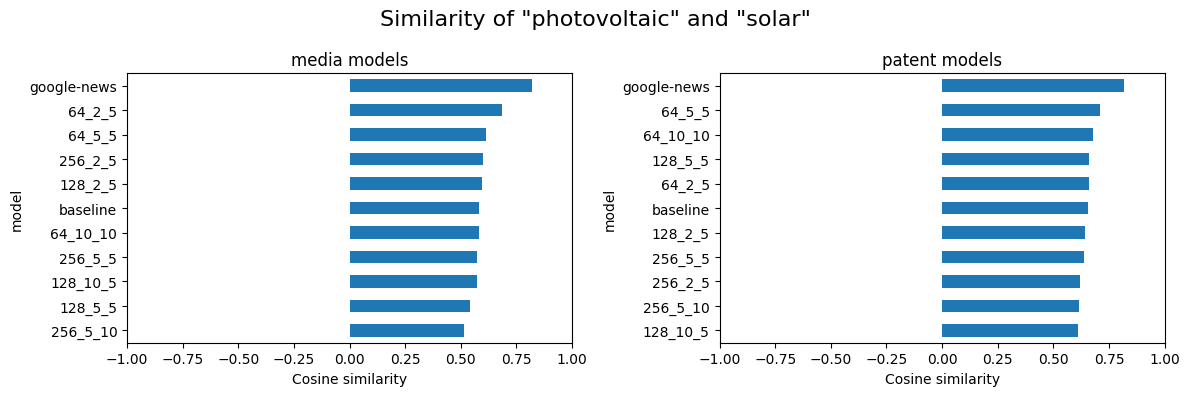

media median: 0.58
patent median: 0.66


In [44]:
plot_word_similarities('photovoltaic', 'solar')

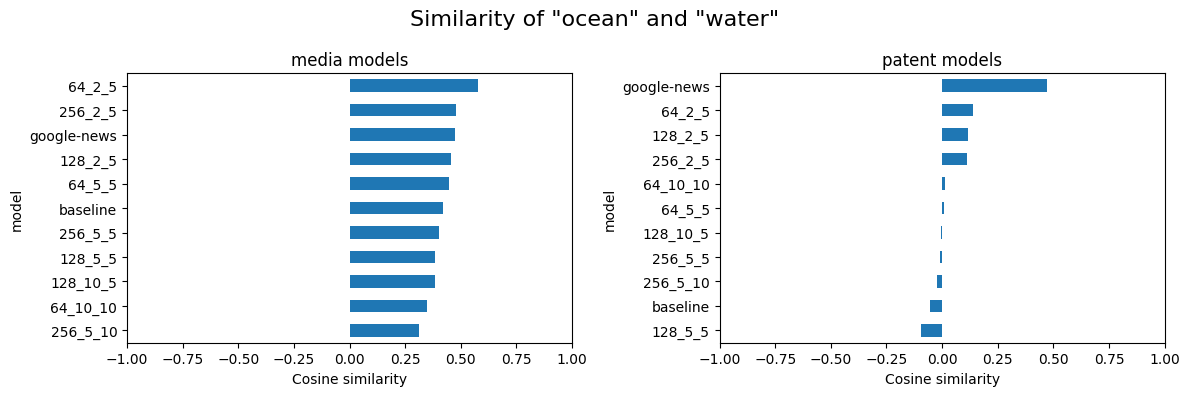

media median: 0.42
patent median: 0.01


In [45]:
plot_word_similarities('ocean', 'water')

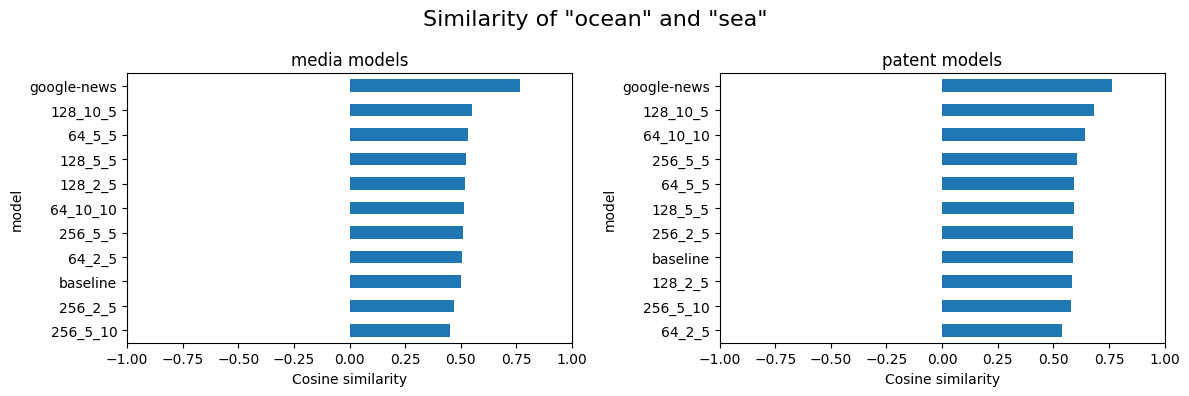

media median: 0.51
patent median: 0.59


In [46]:
plot_word_similarities('ocean', 'sea')

**conclusion** - for the words tested here, the google-news model mostly outperforms our own models. This makes the effort to train our own topic-customised model somewhat pointless. Also in terms of the hyperparameters there seems to be no real tendency towards specific values. Interestingly the patent dataset differs quite a lot from others with the words "ocean" and "water" - might be because the term water in patents probably mostly relates to hydropower, whichs is generated at dams and rivers, not in the ocean.

## Assess dissimilar meanings

When assessing dissimilar meanings, we expect negative values towards `-1`. These are words are generally antonyms - they are used with the same words (related) but have opposite meanings.

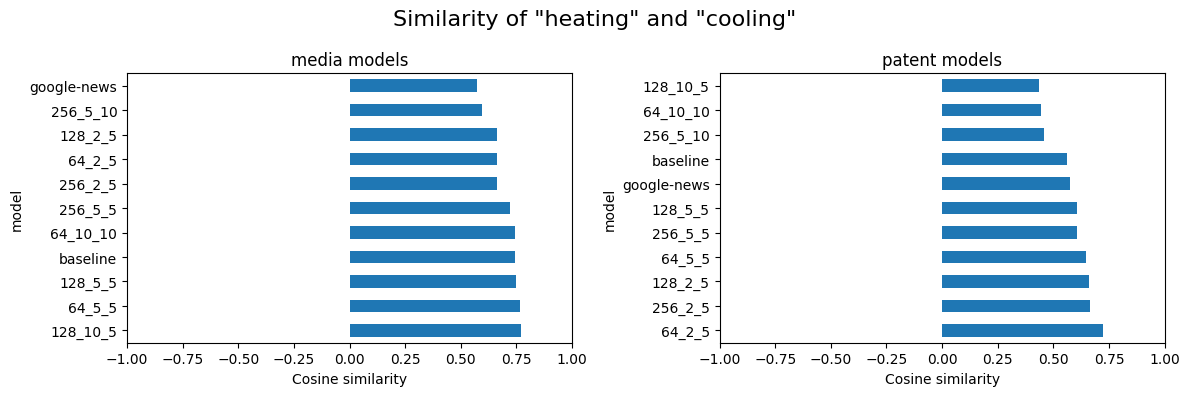

media median: 0.72
patent median: 0.61


In [47]:
plot_word_similarities('heating', 'cooling', ascending=False)

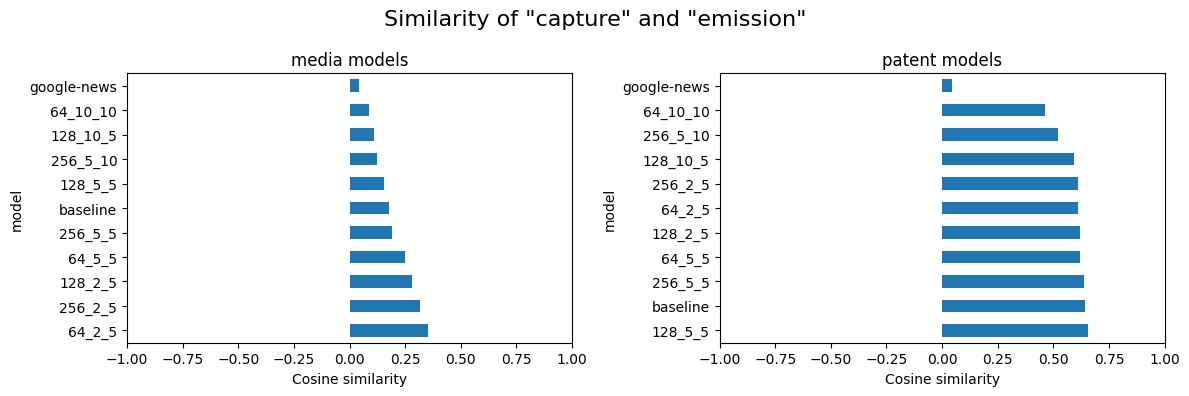

media median: 0.18
patent median: 0.61


In [48]:
plot_word_similarities('capture', 'emission', ascending=False)

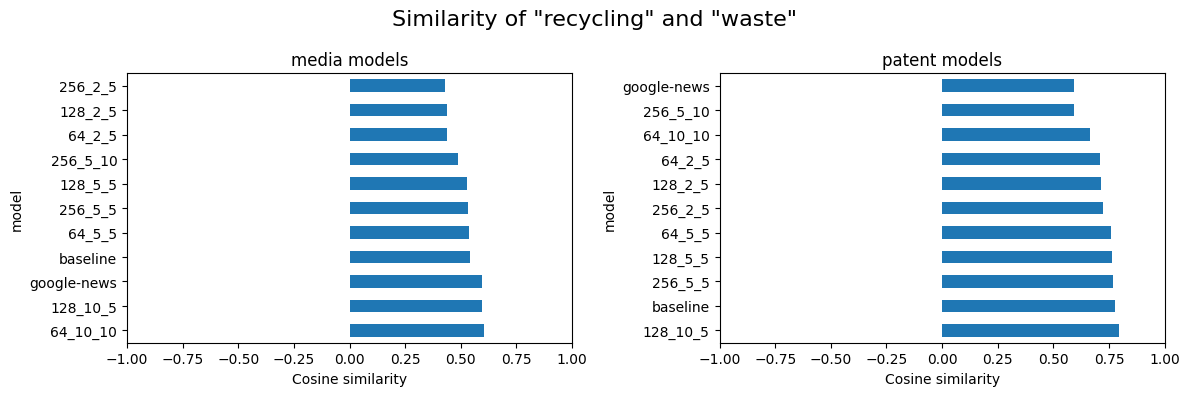

media median: 0.53
patent median: 0.73


In [49]:
plot_word_similarities('recycling', 'waste', ascending=False)

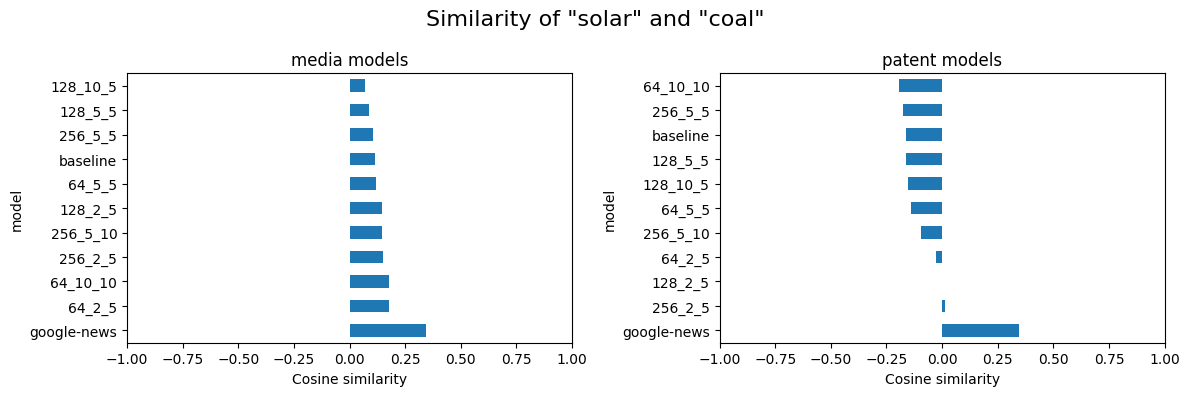

media median: 0.15
patent median: -0.14


In [50]:
plot_word_similarities('solar', 'coal', ascending=False)

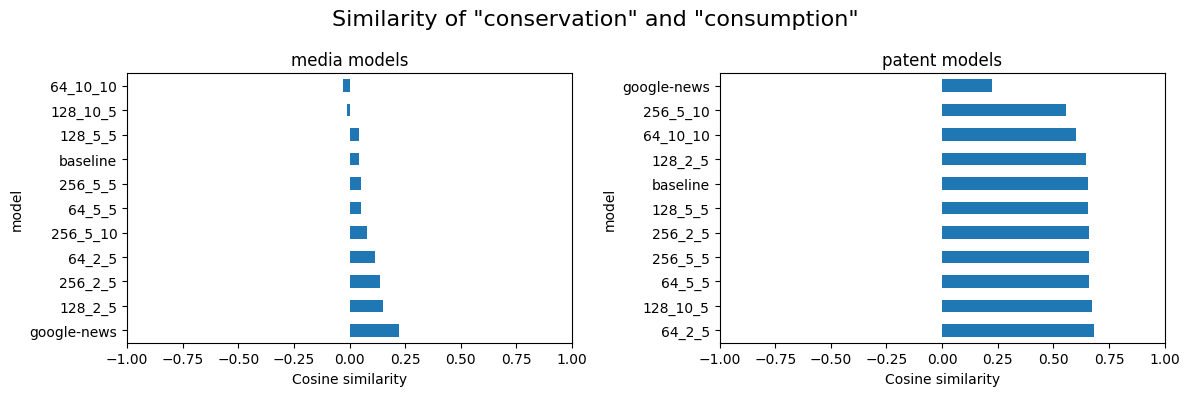

media median: 0.05
patent median: 0.66


In [51]:
plot_word_similarities('conservation', 'consumption', ascending=False)

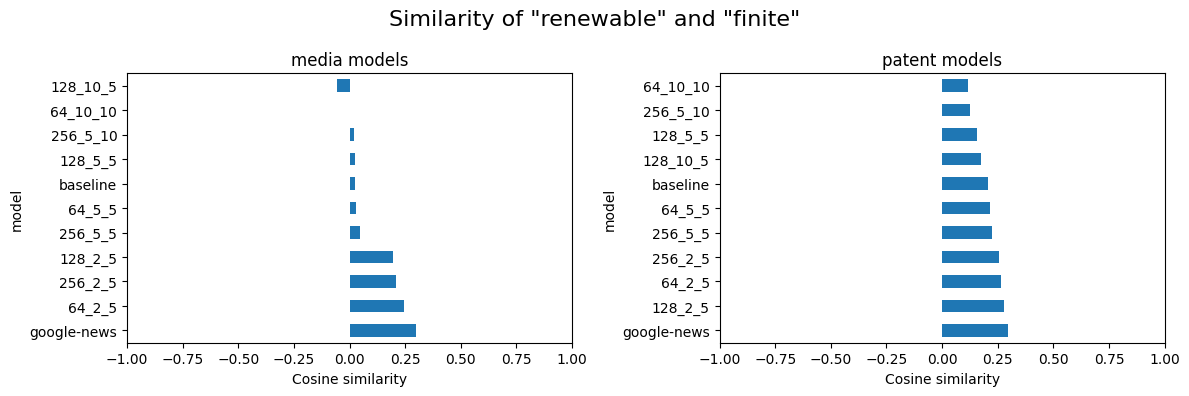

media median: 0.03
patent median: 0.22


In [52]:
plot_word_similarities('renewable', 'finite', ascending=False)

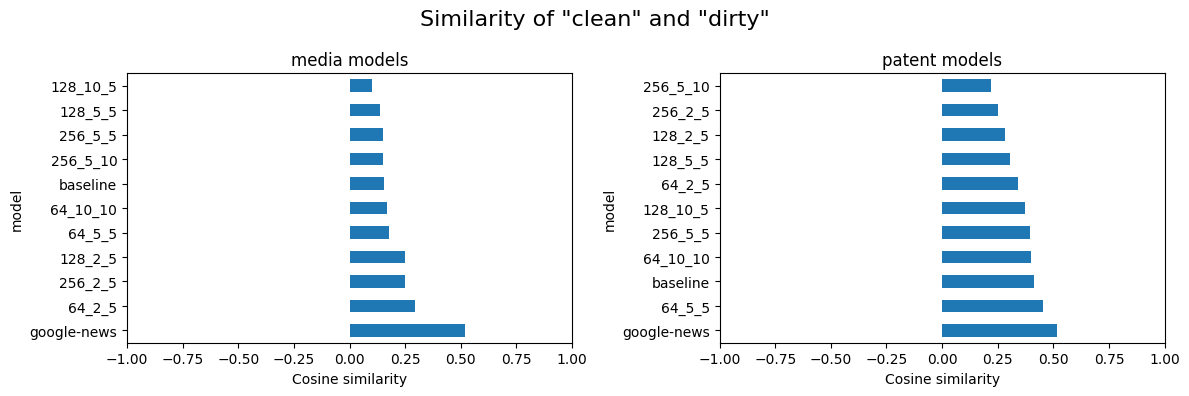

media median: 0.17
patent median: 0.37


In [53]:
plot_word_similarities('clean', 'dirty', ascending=False)

**conclusion** - In this category the google-news model is often outperformed by our models, but still real favourites in terms of hyperparameters. But this interpretation should be treated with caution as we did not see the expected negative values, which means we might have to find oder word pairs to evaluate. One thing to point out is the difference between the two datasets: the contrast between "renewable" and "finite" is better rerpresented in the media-set, whereas the patent-models make a better separation between "solar" and "coil".

## Assess unrelated words

Unrelated words have no dimensions in commom and are orthogonal to each other - their cosine distance should be around `0`

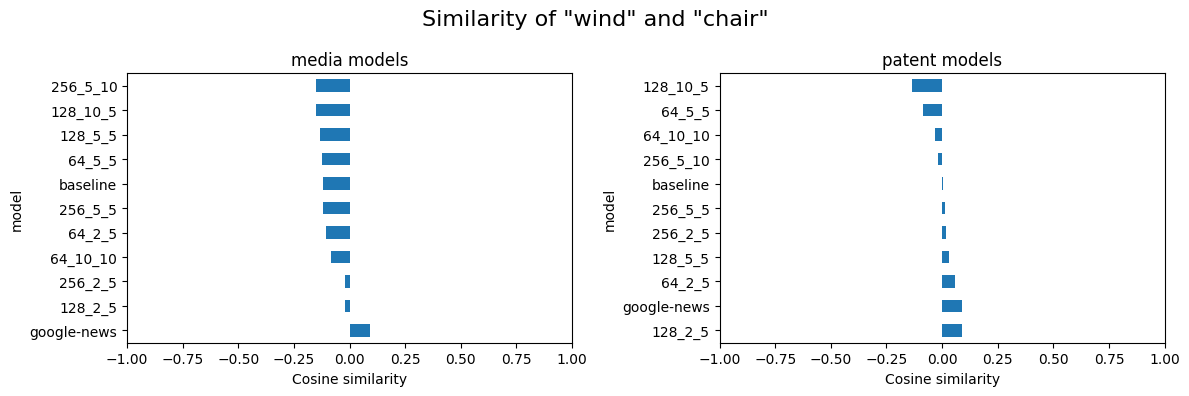

media median: -0.12
patent median: 0.02


In [54]:
plot_word_similarities('wind', 'chair', ascending=False)

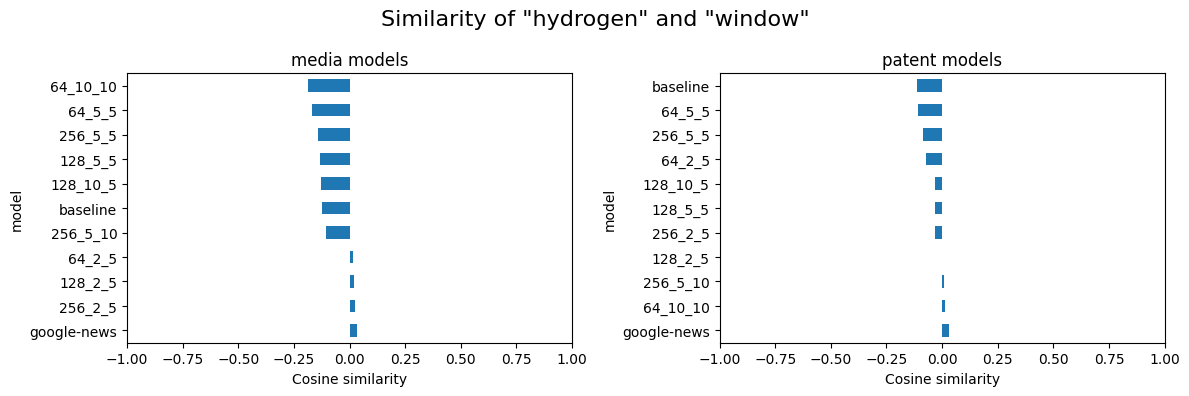

media median: -0.13
patent median: -0.03


In [55]:
plot_word_similarities('hydrogen', 'window', ascending=False)

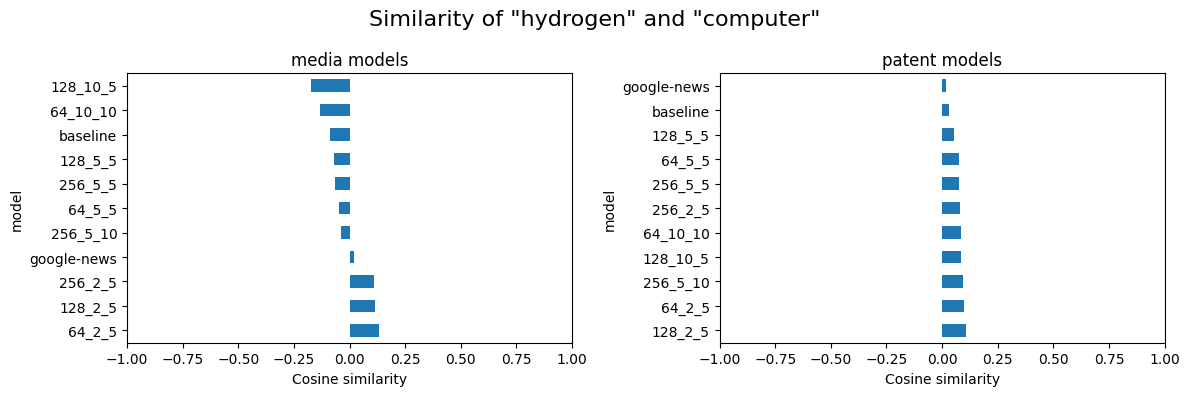

media median: -0.05
patent median: 0.08


In [56]:
plot_word_similarities('hydrogen', 'computer', ascending=False)

**conclusion** - all models do quite well in this category. Overall there is no real preference for the hyperparameters. Although models with smaller windows and less epochs in general seem to have bigger word-similarities, which might mean they are are less opinionated and might more training or context.

## Assessment by dropping words

Another way to assess our models is the `doesnt_match()`-method: It drops the word with the largest distance to the others. Following we print the dropped words per model and our expectations:

In [83]:
TRUE_STYLE = 'color: darkgreen; background: hsl(102 37% 85% / 1);'
FALSE_STYLE = 'color: darkred; background: hsl(0deg 64.52% 87.84%);'

def drop_word(words, expected_drop='oil'):

    media_words = pd.DataFrame([{'model': model_name, 'dropped_word_media': model_vw.doesnt_match(words)}for model_name, model_vw in media_models]).set_index('model')
    patent_words = pd.DataFrame([{'model': model_name, 'dropped_word_patent': model_vw.doesnt_match(words)}for model_name, model_vw in patent_models]).set_index('model')

    df = pd.concat([media_words, patent_words], axis=1)
    
    return df.style.map(lambda x: TRUE_STYLE if x == expected_drop else FALSE_STYLE, subset=['dropped_word_media', 'dropped_word_patent'])

# energy source
drop_word("solar wind biomass coal".split(), expected_drop="coal")

,dropped_word_media,dropped_word_patent
model,,
64_2_5,solar,solar
64_5_5,solar,solar
64_10_10,solar,solar
128_2_5,wind,solar
128_5_5,solar,solar
128_10_5,solar,solar
256_2_5,wind,solar
256_5_5,solar,solar
256_5_10,solar,solar


In [80]:
# heating
drop_word("pellet thermal heatpump gas".lower().split(), expected_drop='gas')

,dropped_word_media,dropped_word_patent
model,,
64_2_5,gas,gas
64_5_5,gas,gas
64_10_10,gas,gas
128_2_5,gas,gas
128_5_5,gas,gas
128_10_5,gas,gas
256_2_5,gas,gas
256_5_5,gas,thermal
256_5_10,gas,gas


In [78]:
# oil vs. wind
drop_word("shell bp drilling oil wind".split(), expected_drop='wind')

,dropped_word_media,dropped_word_patent
model,,
64_2_5,wind,shell
64_5_5,wind,shell
64_10_10,wind,wind
128_2_5,wind,shell
128_5_5,wind,shell
128_10_5,wind,wind
256_2_5,wind,shell
256_5_5,wind,shell
256_5_10,wind,bp


In [88]:
# water related words vs. oil
drop_word("water ocean sea oil".split(), expected_drop='oil')

,dropped_word_media,dropped_word_patent
model,,
64_2_5,oil,ocean
64_5_5,oil,ocean
64_10_10,oil,oil
128_2_5,oil,ocean
128_5_5,oil,oil
128_10_5,oil,oil
256_2_5,oil,ocean
256_5_5,oil,oil
256_5_10,oil,oil


**conclusion** -  also here we see mixed results. The heating part played out really well whereas the enery sources are a complate failure. Maybe the words are to general and are used in other contexts too.

## Geographic assessment

As we have seen in the topic modelling before, there are some geographical patterns in the data. These occur especially in the media-dataset, where we have topics like "Russian Gas Imports" or "Uganda oil projects". Let's see if we can discover the same patterns here.

In [111]:
def print_similar_words(word):
    print('Media:')
    print('------')
    try:
        for model_name, model in media_models:
            words = [word for word, similarity in model.most_similar(word)]
            print(f'{model_name}: {", ".join(words)}' )
    except Exception as error:
        print(error)
    
    print('')
    print('Patent:')
    print('------')
    try:
        for model_name, model in patent_models:
            words = [word for word, similarity in model.most_similar(word)]
            print(f'{model_name}: {", ".join(words)}' )
    except Exception as error:
        print(error)

In [108]:
print_similar_words('russia')

Media:
------
64_2_5: ukraine, invasion, russian, aggression, war, invaded, kremlin, poland, rampage, iran
64_5_5: ukraine, russian, invasion, aggression, war, kremlin, imports, sanctions, unprovoked, algeria
64_10_10: russian, invasion, ukraine, invaded, aggression, unprovoked, war, sanctions, tensions, putin
128_2_5: ukraine, invasion, russian, aggression, war, rampage, invaded, assault, poland, kremlin
128_5_5: ukraine, russian, invasion, aggression, war, kremlin, imports, unprovoked, murderous, sanctions
128_10_5: russian, invasion, ukraine, war, invaded, sanctions, aggression, unprovoked, imports, kremlin
256_2_5: ukraine, russian, invasion, aggression, war, kremlin, invaded, rampage, assault, murderous
256_5_5: ukraine, russian, invasion, war, aggression, kremlin, imports, sanctions, unprovoked, invaded
256_5_10: russian, ukraine, invasion, aggression, war, rampage, unprovoked, invaded, imports, iraq
baseline: russian, ukraine, invasion, aggression, war, imports, kremlin, unprovo

In [112]:
print_similar_words('china')

Media:
------
64_2_5: india, japan, europe, asia, globally, chinese, brazil, germany, vietnam, elsewhere
64_5_5: chinese, japan, india, asian, asia, europe, vietnam, lagging, rivals, thailand
64_10_10: chinese, japan, beijing, vietnam, india, asian, lagging, productronica, asia, thailand
128_2_5: india, japan, asia, europe, vietnam, chinese, tianying, elsewhere, brazil, beijing
128_5_5: chinese, japan, india, vietnam, asian, asia, thailand, lagging, europe, overseas
128_10_5: chinese, asian, japan, india, vietnam, beijing, asia, thailand, malaysia, cambodia
256_2_5: japan, india, asia, beijing, chinese, tianying, vietnam, elsewhere, brazil, lagging
256_5_5: chinese, japan, india, asia, asian, vietnam, beijing, lagging, productronica, thailand
256_5_10: chinese, japan, vietnam, asian, india, asia, thailand, beijing, productronica, lagging
baseline: japan, chinese, india, asian, vietnam, asia, lagging, thailand, rivals, beijing
google-news: dinnerware, crockery, porcelain, crystal_stemwa

In [113]:
print_similar_words('india')

Media:
------
64_2_5: vietnam, uae, indonesia, japan, philippines, singapore, greece, australia, egypt, italy
64_5_5: indonesia, japan, china, italy, uae, vietnam, poland, singapore, morocco, turkey
64_10_10: china, vietnam, singapore, indian, indonesia, uae, spain, japan, malaysia, turkey
128_2_5: indonesia, vietnam, tianying, japan, singapore, lithuania, china, uae, italy, brazil
128_5_5: indonesia, vietnam, japan, uae, singapore, subcontinent, china, greece, italy, malaysia
128_10_5: vietnam, china, spain, poland, indonesia, greece, subcontinent, uae, japan, singapore
256_2_5: vietnam, uae, indonesia, japan, tianying, singapore, china, lithuania, poland, brazil
256_5_5: indonesia, uae, vietnam, japan, singapore, turkey, poland, china, subcontinent, italy
256_5_10: vietnam, china, indonesia, singapore, indian, japan, philippines, uae, province, malaysia
baseline: indonesia, japan, uae, vietnam, turkey, china, italy, poland, singapore, subcontinent
google-news: indian, usa, pakistan, 

In [116]:
print_similar_words('mexico')

Media:
------
64_2_5: zealand, mideast, england, hampshire, jersey, york, brunswick, coast, entrants, papua
64_5_5: zealand, ngi, mideast, england, gulf, coast, gom, louisiana, pennsylvania, jersey
64_10_10: mexican, louisiana, cfe, ngi, entrants, cre, export, reguladora, electricidad, orleans
128_2_5: mideast, zealand, england, maine, brunswick, coast, gom, persian, louisiana, jersey
128_5_5: mideast, zealand, gom, jersey, louisiana, gulf, england, coast, acreage, labrador
128_10_5: ngi, gulf, zealand, mexican, louisiana, gom, jersey, cfe, cre, western
256_2_5: mideast, persian, england, maine, zealand, coast, gom, brunswick, jersey, louisiana
256_5_5: zealand, mideast, louisiana, ngi, gom, persian, england, jersey, pennsylvania, orleans
256_5_10: mideast, zealand, louisiana, hampshire, orleans, mexican, delhi, gulf, entrants, persian
baseline: mideast, zealand, ngi, gom, louisiana, gulf, jersey, pennsylvania, england, labrador
google-news: usa, mexican, las_vegas, america, india, nev

In [117]:
print_similar_words('europe')

Media:
------
64_2_5: continent, uk, asia, country, japan, china, southeast, world, eu, australia
64_5_5: continent, asia, country, china, japan, uk, germany, countries, european, eu
64_10_10: continent, european, europes, germany, asia, country, eu, countries, italy, japan
128_2_5: continent, asia, japan, china, australia, country, eu, southeast, mainland, globe
128_5_5: continent, asia, country, germany, japan, countries, china, european, southeast, eu
128_10_5: continent, european, asia, europes, eu, germany, exporters, ukraine, exports, italy
256_2_5: continent, country, asia, southeast, eu, japan, europes, australia, mainland, germany
256_5_5: continent, asia, country, germany, eu, countries, japan, european, europes, globally
256_5_10: continent, eu, european, europes, germany, country, countries, asia, region, globe
baseline: continent, asia, country, germany, european, eu, japan, globally, exports, countries
google-news: european, germany, spain, england, america, usa, france, 

In [118]:
print_similar_words('uganda')

Media:
------
64_2_5: tanzania, djibouti, ow, pradesh, zambia, malawi, clnr, angola, kuwait, chairwoman
64_5_5: tanzania, chilean, niger, azerbaijan, galla, energa, talos, parish, savannah, brogle
64_10_10: tanzania, azerbaijan, sudan, eacop, rwanda, mali, nigeria, djibouti, kazakhstan, senegal
128_2_5: meudon, nicaragua, tanzania, tempe, clair, ow, providence, colonial, cph, knox
128_5_5: tanzania, chilean, azerbaijan, savannah, sudan, niger, marigold, djibouti, montage, andhra
128_10_5: tanzania, azerbaijan, riau, djibouti, nigeria, kuwait, costa, kazakhstan, republic, midcontinent
256_2_5: tanzania, transwest, ow, clair, socar, iog, bajo, honduras, auvergnerhonealpes, guadeloupe
256_5_5: tanzania, chilean, azerbaijan, pcca, savannah, kuwait, sudan, asx, brogle, niger
256_5_10: tanzania, azerbaijan, sudan, malawi, djibouti, socar, chad, rwanda, niger, honduras
baseline: tanzania, chilean, azerbaijan, savannah, niger, energetyki, kuwait, energa, sudan, djibouti
google-news: kenya, zim

**conclusion** - we can see that for _Russia_ the media dataset is dominated by the russian-ukranian war, which has also been important in terms of gas-deliveries, whereas the google-model serves just general geographical terms (most probably because it originates from times before the war).  

With regards to _China_ Google seems to think the country consists mostly of cockery, whereas our data-models pick up other geographical terms. Interestingly in the patent-set we see a big difference of words within the models, which I can not really explain as of now.

For other parts of the world our models seem to work pretty well in a sence that they pick mostly geographical terms as similar words. But this also means, that there is not much to see.

Author: Pascal Albisser